# **Setting** #

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

%matplotlib inline

# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.time_series.ex3 import *

 # Allows the use of display() for DataFrames
# from IPython.core.interactiveshell import InteractiveShell

# InteractiveShell.ast_node_interactivity = "all"


# Setup notebook
from pathlib import Path
from IPython.display import display

from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import plot_periodogram, seasonal_plot


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from lightgbm import LGBMRegressor # make for microsoft
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import t
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_log_error


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


# **Get Data** #

In [2]:
# Paths
comp_dir = Path('../input/store-sales-time-series-forecasting')

# Get datas
holidays_events = pd.read_csv(
    comp_dir / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family','onpromotion', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

oil = pd.read_csv(
    comp_dir / 'oil.csv',
    usecols = ['date', 'dcoilwtico'],
    dtype={'dcoilwtico': 'float32'    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories()) # assign new columns
)

df_test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
# Rearray to period

transactions =  pd.read_csv( comp_dir / 'transactions.csv',
                            parse_dates = ['date'], 
                            infer_datetime_format = True, 
                            )

transactions['date'] = transactions.date.dt.to_period('D')
transactions = transactions.set_index(['date']).sort_index()
transactions=transactions.squeeze()



oil['date'] = oil.date.dt.to_period('D')
oil = oil.set_index(['date']).sort_index()
oil=oil.squeeze()

store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()




#  **Exploratory Data Analysis** #

In [3]:
display(store_sales.info())
display( store_sales.describe().T)
display( store_sales.head()) 

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3000888 entries, ('1', 'AUTOMOTIVE', Period('2013-01-01', 'D')) to ('9', 'SEAFOOD', Period('2017-08-15', 'D'))
Data columns (total 2 columns):
 #   Column       Dtype  
---  ------       -----  
 0   sales        float32
 1   onpromotion  uint32 
dtypes: float32(1), uint32(1)
memory usage: 34.4 MB


None

,count,mean,std,min,25%,50%,75%,max
sales,3000888.0,356.758392,1093.275879,0.0,0.0,11.0,195.847252,124717.0
onpromotion,3000888.0,2.602770,12.218882,0.0,0.0,0.0,0.000000,741.0


sales  onpromotion
store_nbr family     date                          
1         AUTOMOTIVE 2013-01-01    0.0            0
                     2013-01-02    2.0            0
                     2013-01-03    3.0            0
                     2013-01-04    3.0            0
                     2013-01-05    5.0            0

In [4]:
def decompose_bike_sharing_demand(df, share_type='sales', samples=250, period=30):
    if samples == 'all':
        #decomposing all time series timestamps
        res = seasonal_decompose(df[share_type].values, period=period)
    else:
        #decomposing a sample of the time series
        res = seasonal_decompose(df[share_type].values[-samples:], period=period)
    
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid
    
    #plot the complete time series
    fig, axs = plt.subplots(4, figsize=(16,8))
    axs[0].set_title('OBSERVED', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()
    
    #plot the trend of the time series
    axs[1].set_title('TREND', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()
    
    #plot the seasonality of the time series. Period=24 daily seasonality | Period=24*7 weekly seasonality.
    axs[2].set_title('SEASONALITY', fontsize=16)
    axs[2].plot(seasonal)
    axs[2].grid()
    
    #plot the noise of the time series
    axs[3].set_title('NOISE', fontsize=16)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()
    
    plt.show()
    

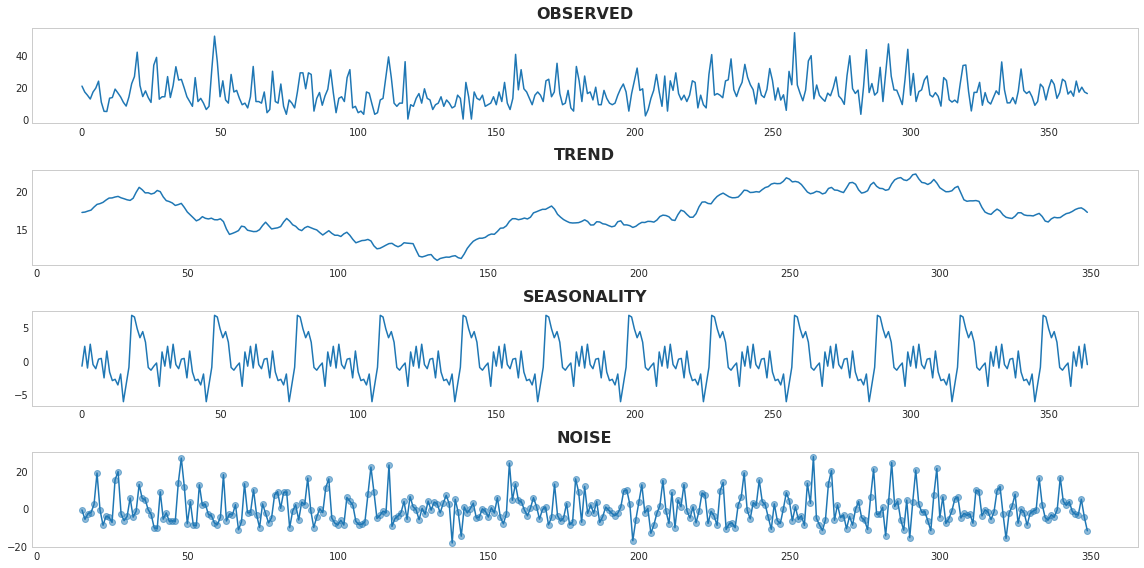

In [5]:
decompose_bike_sharing_demand(store_sales, samples= 365, period = 30 )

In [6]:
# transactions per store
transactions.loc['2017'].info()
transactions.describe()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 12097 entries, 2017-01-01 to 2017-08-15
Freq: D
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   store_nbr     12097 non-null  int64
 1   transactions  12097 non-null  int64
dtypes: int64(2)
memory usage: 283.5 KB


,store_nbr,transactions
count,83488.000000,83488.000000
mean,26.939237,1694.602158
std,15.608204,963.286644
min,1.000000,5.000000
25%,13.000000,1046.000000
50%,27.000000,1393.000000
75%,40.000000,2079.000000
max,54.000000,8359.000000


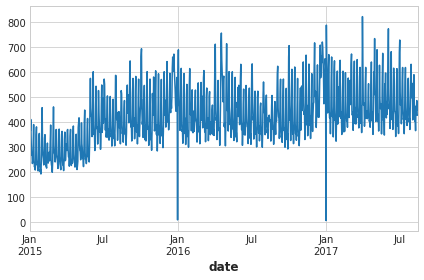

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1684 entries, 2013-01-01 to 2017-08-15
Freq: D
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sales        1684 non-null   float32
 1   onpromotion  1684 non-null   float64
dtypes: float32(1), float64(1)
memory usage: 97.4 KB


In [7]:
# average sales 

average_trans = (
    transactions
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)


average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    
)

#ax = average_sales.plot(**plot_params, alpha = 0.5,  title='Averange Sales', ylabel='Items Sold')
#ax.legend();

average_sales['sales'].loc['2015':].plot()
plt.show()
average_sales.info()

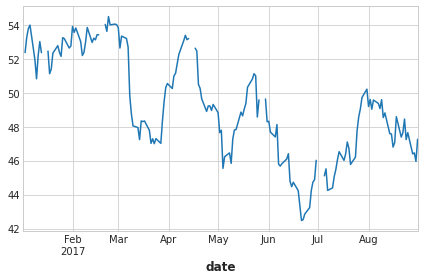

In [8]:
oil['2017'].plot()
plt.show()

# **Model with Oil** #


In [9]:
#y = store_sales.unstack(['store_nbr', 'family']).loc["2017"] 

y = store_sales.unstack(['store_nbr', 'family'])


display(y.head())

# y = y.join( oil.rename('Oil') , on='date').fillna(method = 'bfill')

# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)




X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)
X_holidays = pd.get_dummies(holidays) # add columns on Holidays, more featured, way matricial


#X = X.join( oil.rename('Oil') , on='date').fillna(method = 'bfill')

fourier = CalendarFourier(freq='M', order=4)
dpOil = DeterministicProcess(
    index=oil.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)

Xoil = dpOil.in_sample()



sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0   470.652008   
2013-01-03        3.0       0.0    0.0     919.0   0.0   310.654999   
2013-01-04        3.0       0.0    3.0     953.0   0.0   198.365997   
2013-01-05        5.0       0.0    3.0    1160.0   0.0   301.057007   

                                                    ... onpromotion        \
store_nbr                                           ...           9         
family     CELEBRATION CLEANING  DAIRY        DELI  ...   MAGAZINES MEATS   
date                                                ...                     
2013-01-01         0.0      0.0    0.0    0.000000  ...           0     0   
2013-01-02         0.0   1060.0  579.0  164.069000  ...           0     0   
2013-01-03         0.0    836.0  453.0  151.582001  ...           0     0   
2013-01-04         0.0    827.0  460.0  131.410995  ...           0     0   
2013-01-05         0.0    811.0  464.0  118.612999  ...           0     0   

                                                                       \
store_nbr                                                               
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2013-01-01             0            0                       0       0   
2013-01-02             0            0                       0       0   
2013-01-03             0            0                       0       0   
2013-01-04             0            0                       0       0   
2013-01-05             0            0                       0       0   

                                                                      
store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01              0       0                          0       0  
2013-01-02              0       0                          0       0  
2013-01-03              0       0                          0       0  
2013-01-04              0       0                          0       0  
2013-01-05              0       0                          0       0  

[5 rows x 3564 columns]

In [10]:
X1 = X.join( Xoil , on='date', rsuffix='RT').fillna(method = 'ffill')


In [11]:
#X2 = X1.join(X_holidays, on='date').fillna(0.0)
X2 =X1.copy()
X1.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1684 entries, 2013-01-01 to 2017-08-15
Freq: D
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   const            1684 non-null   float64
 1   trend            1684 non-null   float64
 2   s(2,7)           1684 non-null   float64
 3   s(3,7)           1684 non-null   float64
 4   s(4,7)           1684 non-null   float64
 5   s(5,7)           1684 non-null   float64
 6   s(6,7)           1684 non-null   float64
 7   s(7,7)           1684 non-null   float64
 8   sin(1,freq=M)    1684 non-null   float64
 9   cos(1,freq=M)    1684 non-null   float64
 10  sin(2,freq=M)    1684 non-null   float64
 11  cos(2,freq=M)    1684 non-null   float64
 12  sin(3,freq=M)    1684 non-null   float64
 13  cos(3,freq=M)    1684 non-null   float64
 14  sin(4,freq=M)    1684 non-null   float64
 15  cos(4,freq=M)    1684 non-null   float64
 16  NewYear          1684 non-null   boo

In [12]:
transactions.head()

,store_nbr,transactions
date,,
2013-01-01,25,770
2013-01-02,1,2111
2013-01-02,2,2358
2013-01-02,3,3487
2013-01-02,4,1922


In [13]:
X2['Onpromotion'] =  average_sales['onpromotion']
X3= X2.copy()

X5= X3.join(average_trans, on='date')

#transactions.reset_index(inplace=True)
#X2['Store_nbr'] =  transactions['store_nbr']
#X3['Transactions'] =  transactions['transactions']
X3.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1684 entries, 2013-01-01 to 2017-08-15
Freq: D
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   const            1684 non-null   float64
 1   trend            1684 non-null   float64
 2   s(2,7)           1684 non-null   float64
 3   s(3,7)           1684 non-null   float64
 4   s(4,7)           1684 non-null   float64
 5   s(5,7)           1684 non-null   float64
 6   s(6,7)           1684 non-null   float64
 7   s(7,7)           1684 non-null   float64
 8   sin(1,freq=M)    1684 non-null   float64
 9   cos(1,freq=M)    1684 non-null   float64
 10  sin(2,freq=M)    1684 non-null   float64
 11  cos(2,freq=M)    1684 non-null   float64
 12  sin(3,freq=M)    1684 non-null   float64
 13  cos(3,freq=M)    1684 non-null   float64
 14  sin(4,freq=M)    1684 non-null   float64
 15  cos(4,freq=M)    1684 non-null   float64
 16  NewYear          1684 non-null   boo

In [14]:
#X5.dropna(how='any', axis=0, inplace=True) # drop values NaNs

#X5.head(-20)

In [15]:
X3['Oil'] = oil
X3['OilLagsOne'] = oil.shift(periods=1, freq='D')
X3.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1684 entries, 2013-01-01 to 2017-08-15
Freq: D
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   const            1684 non-null   float64
 1   trend            1684 non-null   float64
 2   s(2,7)           1684 non-null   float64
 3   s(3,7)           1684 non-null   float64
 4   s(4,7)           1684 non-null   float64
 5   s(5,7)           1684 non-null   float64
 6   s(6,7)           1684 non-null   float64
 7   s(7,7)           1684 non-null   float64
 8   sin(1,freq=M)    1684 non-null   float64
 9   cos(1,freq=M)    1684 non-null   float64
 10  sin(2,freq=M)    1684 non-null   float64
 11  cos(2,freq=M)    1684 non-null   float64
 12  sin(3,freq=M)    1684 non-null   float64
 13  cos(3,freq=M)    1684 non-null   float64
 14  sin(4,freq=M)    1684 non-null   float64
 15  cos(4,freq=M)    1684 non-null   float64
 16  NewYear          1684 non-null   boo

In [16]:
#X5.fillna(method='bfill',  inplace=True) # drop values NaNs

X3.dropna(how='any', axis=0, inplace=True) # drop values NaNs



In [17]:
display(y.info())
y.head()


<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1684 entries, 2013-01-01 to 2017-08-15
Freq: D
Columns: 3564 entries, ('sales', '1', 'AUTOMOTIVE') to ('onpromotion', '9', 'SEAFOOD')
dtypes: float32(1782), uint32(1782)
memory usage: 22.9 MB


None

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0   470.652008   
2013-01-03        3.0       0.0    0.0     919.0   0.0   310.654999   
2013-01-04        3.0       0.0    3.0     953.0   0.0   198.365997   
2013-01-05        5.0       0.0    3.0    1160.0   0.0   301.057007   

                                                    ... onpromotion        \
store_nbr                                           ...           9         
family     CELEBRATION CLEANING  DAIRY        DELI  ...   MAGAZINES MEATS   
date                                                ...                     
2013-01-01         0.0      0.0    0.0    0.000000  ...           0     0   
2013-01-02         0.0   1060.0  579.0  164.069000  ...           0     0   
2013-01-03         0.0    836.0  453.0  151.582001  ...           0     0   
2013-01-04         0.0    827.0  460.0  131.410995  ...           0     0   
2013-01-05         0.0    811.0  464.0  118.612999  ...           0     0   

                                                                       \
store_nbr                                                               
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2013-01-01             0            0                       0       0   
2013-01-02             0            0                       0       0   
2013-01-03             0            0                       0       0   
2013-01-04             0            0                       0       0   
2013-01-05             0            0                       0       0   

                                                                      
store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01              0       0                          0       0  
2013-01-02              0       0                          0       0  
2013-01-03              0       0                          0       0  
2013-01-04              0       0                          0       0  
2013-01-05              0       0                          0       0  

[5 rows x 3564 columns]

In [18]:
timeInitial = '2016'
Xtrain = X3.copy().loc[timeInitial:] 
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 321 entries, 2016-01-05 to 2017-08-15
Freq: D
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   const            321 non-null    float64
 1   trend            321 non-null    float64
 2   s(2,7)           321 non-null    float64
 3   s(3,7)           321 non-null    float64
 4   s(4,7)           321 non-null    float64
 5   s(5,7)           321 non-null    float64
 6   s(6,7)           321 non-null    float64
 7   s(7,7)           321 non-null    float64
 8   sin(1,freq=M)    321 non-null    float64
 9   cos(1,freq=M)    321 non-null    float64
 10  sin(2,freq=M)    321 non-null    float64
 11  cos(2,freq=M)    321 non-null    float64
 12  sin(3,freq=M)    321 non-null    float64
 13  cos(3,freq=M)    321 non-null    float64
 14  sin(4,freq=M)    321 non-null    float64
 15  cos(4,freq=M)    321 non-null    float64
 16  NewYear          321 non-null    bool

In [19]:
dateRange =  Xtrain.index

label = store_sales.unstack(['store_nbr', 'family']).loc[dateRange] # include el range de X3
label.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 321 entries, 2016-01-05 to 2017-08-15
Freq: D
Columns: 3564 entries, ('sales', '1', 'AUTOMOTIVE') to ('onpromotion', '9', 'SEAFOOD')
dtypes: float32(1782), uint32(1782)
memory usage: 4.4 MB


In [20]:
#model = LinearRegression(fit_intercept=False)
model = RandomForestRegressor(random_state = 42)

# model = LGBMRegressor(random_state = 42) "not work with  mulpli-columns"

model.fit(Xtrain, label)
y_pred = pd.DataFrame(model.predict(Xtrain), index=Xtrain.index, columns=y.columns)
y_pred.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 321 entries, 2016-01-05 to 2017-08-15
Freq: D
Columns: 3564 entries, ('sales', '1', 'AUTOMOTIVE') to ('onpromotion', '9', 'SEAFOOD')
dtypes: float64(3564)
memory usage: 8.7 MB


CategoricalIndex(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
                  'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI',
                  'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II',
                  'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II',
                  'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR',
                  'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER',
                  'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES',
                  'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS',
                  'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'],
                 categories=['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', ...], ordered=False, dtype='category', name='family')

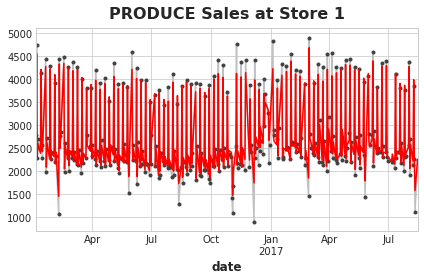

In [21]:
STORE_NBR = '1'  # 1 - 54
FAMILY = 'PRODUCE'
# Uncomment to see a list of product families
display(store_sales.index.get_level_values('family').unique())

ax = label.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params) # choose single store 1 and family equal produce. 
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax, color='red')
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

### Metric ###

In [22]:
Y = label.loc(axis=1)['sales', STORE_NBR, FAMILY]
Ypred = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY]

mae = np.round(mean_absolute_error(Y, Ypred), 3)    

msle =  np.round(mean_squared_log_error(Y, Ypred), 3 )
print( mae, '--' , msle)

105.43 -- 0.006


In [23]:
X4 = Xtrain.columns

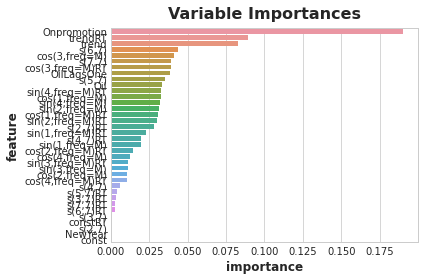

In [24]:
    #create a dataframe with the variable importances of the model
    df_importances = pd.DataFrame({
        'feature': X4,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False)
    
    #plot variable importances of the model
    plt.title('Variable Importances', fontsize=16)
    sns.barplot(x=df_importances.importance, y=df_importances.feature, orient='h')
    plt.show()

In [25]:
def train_time_series_with_folds(df, horizon=7*2):
    X = df.drop('count', axis=1)
    y = df['count']
    
    #take last week of the dataset for validation
    X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
    y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]
    
    #create, train and do inference of the model
    model = LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    #calculate MAE
    mae = np.round(mean_absolute_error(y_test, predictions), 3)    
    
    #plot reality vs prediction for the last week of the dataset
    fig = plt.figure(figsize=(16,8))
    plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
    plt.plot(y_test, color='red')
    plt.plot(pd.Series(predictions, index=y_test.index), color='green')
    plt.xlabel('Hour', fontsize=16)
    plt.ylabel('Number of Shared Bikes', fontsize=16)
    plt.legend(labels=['Real', 'Prediction'], fontsize=16)
    plt.grid()
    plt.show()
    
    #create a dataframe with the variable importances of the model
    df_importances = pd.DataFrame({
        'feature': model.feature_name_,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False)
    
    #plot variable importances of the model
    plt.title('Variable Importances', fontsize=16)
    sns.barplot(x=df_importances.importance, y=df_importances.feature, orient='h')
    plt.show()

We see a low in the price oil, at the end of 2014.

### Missing Values ###

In [26]:
df_test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [27]:


average_sales_test = (
    df_test
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

average_sales

,sales,onpromotion
date,,
2013-01-01,1.409438,0.000000
2013-01-02,278.390808,0.000000
2013-01-03,202.840195,0.000000
2013-01-04,198.911148,0.000000
2013-01-05,267.873230,0.000000
...,...,...
2017-08-11,463.733856,7.956790
2017-08-12,444.798279,4.664422
2017-08-13,485.768616,5.209315


In [28]:
#df_test = df_test.loc['2017'] 
# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 16 entries, 2017-08-16 to 2017-08-31
Freq: D
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   const          16 non-null     float64
 1   trend          16 non-null     float64
 2   s(2,7)         16 non-null     float64
 3   s(3,7)         16 non-null     float64
 4   s(4,7)         16 non-null     float64
 5   s(5,7)         16 non-null     float64
 6   s(6,7)         16 non-null     float64
 7   s(7,7)         16 non-null     float64
 8   sin(1,freq=M)  16 non-null     float64
 9   cos(1,freq=M)  16 non-null     float64
 10  sin(2,freq=M)  16 non-null     float64
 11  cos(2,freq=M)  16 non-null     float64
 12  sin(3,freq=M)  16 non-null     float64
 13  cos(3,freq=M)  16 non-null     float64
 14  sin(4,freq=M)  16 non-null     float64
 15  cos(4,freq=M)  16 non-null     float64
 16  NewYear        16 non-null     bool   
dtypes: bool(1), float64(16)
memory

In [29]:
#X_test2 = X_test.join(aveShift.rename('daysLags') , on='date').fillna(0.0)
print('Done')

Done


In [30]:

#X_test['dayslags'] = average_sales['sales'].loc[' 2017-08-16': '2017-08-30'] # last 15 days
#X_test.dropna(how='any', axis=0, inplace=True)
#X_test.info()
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 321 entries, 2016-01-05 to 2017-08-15
Freq: D
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   const            321 non-null    float64
 1   trend            321 non-null    float64
 2   s(2,7)           321 non-null    float64
 3   s(3,7)           321 non-null    float64
 4   s(4,7)           321 non-null    float64
 5   s(5,7)           321 non-null    float64
 6   s(6,7)           321 non-null    float64
 7   s(7,7)           321 non-null    float64
 8   sin(1,freq=M)    321 non-null    float64
 9   cos(1,freq=M)    321 non-null    float64
 10  sin(2,freq=M)    321 non-null    float64
 11  cos(2,freq=M)    321 non-null    float64
 12  sin(3,freq=M)    321 non-null    float64
 13  cos(3,freq=M)    321 non-null    float64
 14  sin(4,freq=M)    321 non-null    float64
 15  cos(4,freq=M)    321 non-null    float64
 16  NewYear          321 non-null    bool

In [31]:
#X_test = X_test.join( oil.rename('Oil') , on='date').fillna(method = 'bfill')
#X_test1 = X_test.join( Xoil , on='date', rsuffix='RT').fillna(method = 'bfill')
#X_test1.info()
X1_test = X_test.join( Xoil , on='date', rsuffix='RT').fillna(method = 'ffill')


#X2_test = X1_test.join(X_holidays, on='date').fillna(0.0)
X1_test.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 16 entries, 2017-08-16 to 2017-08-31
Freq: D
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   const            16 non-null     float64
 1   trend            16 non-null     float64
 2   s(2,7)           16 non-null     float64
 3   s(3,7)           16 non-null     float64
 4   s(4,7)           16 non-null     float64
 5   s(5,7)           16 non-null     float64
 6   s(6,7)           16 non-null     float64
 7   s(7,7)           16 non-null     float64
 8   sin(1,freq=M)    16 non-null     float64
 9   cos(1,freq=M)    16 non-null     float64
 10  sin(2,freq=M)    16 non-null     float64
 11  cos(2,freq=M)    16 non-null     float64
 12  sin(3,freq=M)    16 non-null     float64
 13  cos(3,freq=M)    16 non-null     float64
 14  sin(4,freq=M)    16 non-null     float64
 15  cos(4,freq=M)    16 non-null     float64
 16  NewYear          16 non-null     bool 

In [32]:
#X2_test['daysLags']= average_sales['sales'].shift(periods=16, freq='D') # last 15 days, include extension it could is correct... 
#X2_test['daysweeklags'] = average_sales['sales'].shift(periods=16, freq='D')

#X2_test['OPaverage'] =  average_sales_test['onpromotion']

#aveShift = average_sales['sales'].shift(periods=15, freq='D') # last 15 days

#aveShift.dropna(how='any', axis=0, inplace=True)
X2_test =  X1_test.copy()
X2_test.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 16 entries, 2017-08-16 to 2017-08-31
Freq: D
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   const            16 non-null     float64
 1   trend            16 non-null     float64
 2   s(2,7)           16 non-null     float64
 3   s(3,7)           16 non-null     float64
 4   s(4,7)           16 non-null     float64
 5   s(5,7)           16 non-null     float64
 6   s(6,7)           16 non-null     float64
 7   s(7,7)           16 non-null     float64
 8   sin(1,freq=M)    16 non-null     float64
 9   cos(1,freq=M)    16 non-null     float64
 10  sin(2,freq=M)    16 non-null     float64
 11  cos(2,freq=M)    16 non-null     float64
 12  sin(3,freq=M)    16 non-null     float64
 13  cos(3,freq=M)    16 non-null     float64
 14  sin(4,freq=M)    16 non-null     float64
 15  cos(4,freq=M)    16 non-null     float64
 16  NewYear          16 non-null     bool 

In [33]:
X2_test.head(20)

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,"s(6,7)RT","s(7,7)RT","sin(1,freq=M)RT","cos(1,freq=M)RT","sin(2,freq=M)RT","cos(2,freq=M)RT","sin(3,freq=M)RT","cos(3,freq=M)RT","sin(4,freq=M)RT","cos(4,freq=M)RT"
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,1.0,1685.0,0.0,0.0,0.0,1.0,0.0,0.0,0.101168,-0.994869,...,0.0,0.0,0.101168,-0.994869,-0.201299,0.979530,0.299363,-0.954139,-0.394356,0.918958
2017-08-17,1.0,1686.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.101168,-0.994869,...,0.0,0.0,-0.101168,-0.994869,0.201299,0.979530,-0.299363,-0.954139,0.394356,0.918958
2017-08-18,1.0,1687.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.299363,-0.954139,...,0.0,0.0,-0.299363,-0.954139,0.571268,0.820763,-0.790776,-0.612106,0.937752,0.347305
2017-08-19,1.0,1688.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.485302,-0.874347,...,0.0,0.0,-0.299363,-0.954139,0.571268,0.820763,-0.790776,-0.612106,0.937752,0.347305
2017-08-20,1.0,1689.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.651372,-0.758758,...,0.0,0.0,-0.299363,-0.954139,0.571268,0.820763,-0.790776,-0.612106,0.937752,0.347305
2017-08-21,1.0,1690.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.790776,-0.612106,...,1.0,0.0,-0.790776,-0.612106,0.968077,-0.250653,-0.394356,0.918958,-0.485302,-0.874347
2017-08-22,1.0,1691.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.897805,-0.440394,...,0.0,1.0,-0.897805,-0.440394,0.790776,-0.612106,0.201299,0.979530,-0.968077,-0.250653
2017-08-23,1.0,1692.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.968077,-0.250653,...,0.0,0.0,-0.968077,-0.250653,0.485302,-0.874347,0.724793,0.688967,-0.848644,0.528964
2017-08-24,1.0,1693.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.998717,-0.050649,...,0.0,0.0,-0.998717,-0.050649,0.101168,-0.994869,0.988468,0.151428,-0.201299,0.979530


In [34]:
X2_test['Onpromotion'] =  average_sales_test['onpromotion']

X2_test['Oil'] = oil
X2_test['OilLagsOne'] = oil.shift(periods=1, freq='D')

X2_test.info()


<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 16 entries, 2017-08-16 to 2017-08-31
Freq: D
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   const            16 non-null     float64
 1   trend            16 non-null     float64
 2   s(2,7)           16 non-null     float64
 3   s(3,7)           16 non-null     float64
 4   s(4,7)           16 non-null     float64
 5   s(5,7)           16 non-null     float64
 6   s(6,7)           16 non-null     float64
 7   s(7,7)           16 non-null     float64
 8   sin(1,freq=M)    16 non-null     float64
 9   cos(1,freq=M)    16 non-null     float64
 10  sin(2,freq=M)    16 non-null     float64
 11  cos(2,freq=M)    16 non-null     float64
 12  sin(3,freq=M)    16 non-null     float64
 13  cos(3,freq=M)    16 non-null     float64
 14  sin(4,freq=M)    16 non-null     float64
 15  cos(4,freq=M)    16 non-null     float64
 16  NewYear          16 non-null     bool 

In [35]:
X2_test.fillna(method='ffill', inplace=True)


X2_test.head(20)

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,"cos(1,freq=M)RT","sin(2,freq=M)RT","cos(2,freq=M)RT","sin(3,freq=M)RT","cos(3,freq=M)RT","sin(4,freq=M)RT","cos(4,freq=M)RT",Onpromotion,Oil,OilLagsOne
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,1.0,1685.0,0.0,0.0,0.0,1.0,0.0,0.0,0.101168,-0.994869,...,-0.994869,-0.201299,0.979530,0.299363,-0.954139,-0.394356,0.918958,17.137486,46.799999,47.570000
2017-08-17,1.0,1686.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.101168,-0.994869,...,-0.994869,0.201299,0.979530,-0.299363,-0.954139,0.394356,0.918958,4.211560,47.070000,46.799999
2017-08-18,1.0,1687.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.299363,-0.954139,...,-0.954139,0.571268,0.820763,-0.790776,-0.612106,0.937752,0.347305,7.731201,48.590000,47.070000
2017-08-19,1.0,1688.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.485302,-0.874347,...,-0.954139,0.571268,0.820763,-0.790776,-0.612106,0.937752,0.347305,4.833895,48.590000,48.590000
2017-08-20,1.0,1689.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.651372,-0.758758,...,-0.954139,0.571268,0.820763,-0.790776,-0.612106,0.937752,0.347305,5.338384,48.590000,48.590000
2017-08-21,1.0,1690.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.790776,-0.612106,...,-0.612106,0.968077,-0.250653,-0.394356,0.918958,-0.485302,-0.874347,4.545455,47.389999,48.590000
2017-08-22,1.0,1691.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.897805,-0.440394,...,-0.440394,0.790776,-0.612106,0.201299,0.979530,-0.968077,-0.250653,5.777217,47.650002,47.389999
2017-08-23,1.0,1692.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.968077,-0.250653,...,-0.250653,0.485302,-0.874347,0.724793,0.688967,-0.848644,0.528964,9.259259,48.450001,47.650002
2017-08-24,1.0,1693.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.998717,-0.050649,...,-0.050649,0.101168,-0.994869,0.988468,0.151428,-0.201299,0.979530,4.639731,47.240002,48.450001


In [36]:
#X2_test.dropna(how='any', axis=0, inplace=True) # drop values NaNs

X2_test.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 16 entries, 2017-08-16 to 2017-08-31
Freq: D
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   const            16 non-null     float64
 1   trend            16 non-null     float64
 2   s(2,7)           16 non-null     float64
 3   s(3,7)           16 non-null     float64
 4   s(4,7)           16 non-null     float64
 5   s(5,7)           16 non-null     float64
 6   s(6,7)           16 non-null     float64
 7   s(7,7)           16 non-null     float64
 8   sin(1,freq=M)    16 non-null     float64
 9   cos(1,freq=M)    16 non-null     float64
 10  sin(2,freq=M)    16 non-null     float64
 11  cos(2,freq=M)    16 non-null     float64
 12  sin(3,freq=M)    16 non-null     float64
 13  cos(3,freq=M)    16 non-null     float64
 14  sin(4,freq=M)    16 non-null     float64
 15  cos(4,freq=M)    16 non-null     float64
 16  NewYear          16 non-null     bool 

In [37]:
y_submit = pd.DataFrame(model.predict(X2_test), index=X2_test.index, columns=y.columns)
y_submit.head()

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-08-16       3.29       0.0   4.35   2425.33  1.15   420.184339   
2017-08-17       5.00       0.0   4.47   2153.24  0.21   358.613649   
2017-08-18       5.95       0.0   2.75   2049.74  0.06   318.079189   
2017-08-19       4.45       0.0   3.79   2331.19  0.19   366.942074   
2017-08-20       4.15       0.0   3.52   2360.83  0.20   368.308303   

                                                     ... onpromotion         \
store_nbr                                            ...           9          
family     CELEBRATION CLEANING   DAIRY        DELI  ...   MAGAZINES  MEATS   
date                                                 ...                      
2017-08-16       23.56   842.85  841.68  143.688759  ...         0.0   0.36   
2017-08-17       19.39   680.40  722.61  123.560960  ...         0.0  18.97   
2017-08-18       16.39   632.56  627.04  138.576431  ...         0.0   0.94   
2017-08-19       15.97   721.83  703.81  137.588169  ...         0.0   6.55   
2017-08-20       16.21   742.80  708.23  135.625029  ...         0.0   5.97   

                                                                       \
store_nbr                                                               
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2017-08-16         14.91         0.16                    0.34    1.42   
2017-08-17         10.85         0.00                    0.03    0.13   
2017-08-18         10.94         0.01                    0.00   16.19   
2017-08-19         10.91         0.00                    0.01    1.55   
2017-08-20         11.13         0.00                    0.01    2.05   

                                                                      
store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2017-08-16           2.89    5.92                       0.61    0.53  
2017-08-17           0.48   16.20                       2.13    0.19  
2017-08-18           2.04   36.87                       4.07    0.10  
2017-08-19           0.55   94.72                       2.70    0.24  
2017-08-20           0.63   95.91                       2.38    0.20  

[5 rows x 3564 columns]

In [38]:
y_submit = pd.DataFrame(model.predict(X2_test), index=X2_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)

In [39]:
print('18:50')
y_submit.shape


18:50


(28512, 2)

## Pre-Processing ##

### Selection only Giants or Dwarfs ###

## Balance ##

In [40]:
# dividir set 



# from sklearn.utils import resample
# dfGiantsDownSample = resample(dfGiants, 
  #                           replace = False, # sample without replacement
   #                          n_samples = num_of_dwarf,
   #                          random_state =1 
 #                            )
#dfDownSampled = pd.concat([dfGiantsDownSample , dfDwarfs] )

#dfBalanced= dfDownSampled.reset_index(drop=True)

# dataStar = dfBalanced.sample(frac=1).reset_index(drop=True) # shuffle
# dfCopyStar = dataStar.copy()

## Visualization ##

## Correlation Linear ##

## Data Cleaning ##

# **Data Processing** #

### Train and test Set ###

In [41]:
## Stratified ##
#from sklearn.model_selection import StratifiedShuffleSplit
#split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#for train_index, test_index in split.split(data, data["variableStratificada"]):
#strat_train_set = housing.loc[train_index]
#strat_test_set = housing.loc[test_index]

#from  sklearn.impute import SimpleImputer
#imputer = SimpleImputer(strategy='median')

#from  sklearn.preprocessing import OneHotEncoder
#catEncoder = OneHotEncoder()

## numerical ##
#from  sklearn.pipeline import Pipeline
#from  sklearn.preprocessing import StandardScaler
#numerical_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),('attribs_adder', CombinedAttributesAdder()),])
# new_variable_transformed_numerical = num_pipeline.fit_transform(varible_numerica)

## numerical and categorial ##
#from sklearn import ColumnTransformer
#numerical_attribs = list(numerical_columns)
#categorical_attribs = list(categorial_columns)
#full_pipeline = ColumnTransformer([("num", numerical_pipeline, numerical_attribs),("cat", OneHotEncoder(), categorical_attribs),])
#dataTotal_prepared = full_pipeline.fit_transform(dataTotal) 

## Target ## 

## Featuring Engineering ##

##  Pipeline and Featuring Scaling ##

 # **MODEL** # 

#### Models ####

In [42]:
### stratified CV ### see pag 136  Geron's book
#from sklearn.model_selection import StratifiedKFold
#from sklearn.base import clone
#skfolds = StratifiedKFold(n_splits=3, random_state=42)

# **Refinament** #

# **Deploy** #